# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




#  Naive Bayes Algorithm

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Import Required Packages

# Applying Multinomial Naive Bayes

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data prerocessing related
from sklearn.preprocessing import StandardScaler

# import model related packages
from sklearn.naive_bayes import MultinomialNB

# import model selection packages
from sklearn.model_selection import StratifiedKFold

# import model evaluation related packages
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc, roc_curve
from scipy import interp

# calibration related package
from sklearn.calibration import CalibratedClassifierCV

# visualization related packages
from wordcloud import WordCloud
from prettytable import PrettyTable

# UTIL functions

## Data Preprocessing Related Functions

In [2]:
def preprocess_data(config_dict, scaling=True, dim_reduction=False):
    """
    This function does preprocessing of data such as column standardization and
    dimensionality reduction using Truncated SVD
    """
    
    # Read train, test data frames & truncate it as needed
    train_df = pd.read_csv(config_dict['train_csv_path'], index_col=False)
    train_df = train_df.iloc[0:config_dict['train_size']]
    test_df = pd.read_csv(config_dict['test_csv_path'], index_col=False)
    test_df = test_df.iloc[0:config_dict['test_size']]

    # print the statisics of train, test df
    print('Train df shape',train_df.shape)
    print('Class label distribution in train df:\n', train_df['Label'].value_counts())
    print('Test df shape',test_df.shape)
    print('Class label distribution in test df:\n', test_df['Label'].value_counts())

    # separate features and labels
    train_features = train_df.drop(['Label', 'Id'], axis=1)    
    train_labels = train_df['Label']
    test_features = test_df.drop(['Label', 'Id'], axis=1)
    test_labels = test_df['Label']
    
    # set feature names
    feature_name_list = train_features.columns.values.tolist()
    
    # If Scaling is opted scale the train, test data
    if scaling:
        standard_scaler = StandardScaler()
        standard_scaler.fit(train_features)
    
        train_features = pd.DataFrame(standard_scaler.transform(train_features), 
                                      columns=feature_name_list)
        test_features = pd.DataFrame(standard_scaler.transform(test_features),
                                     columns=feature_name_list)
                             
    print('Shape of ->  train features :%d,%d, test features: %d,%d'%(train_features.shape +  
                                                                      test_features.shape))
    print('Shape of -> train labels :%d, test labels: %d'%(train_labels.shape[0], 
                                                           test_labels.shape[0],))
    
    # if dim reduction is opted, reduce the dimension
    if dim_reduction:
        # create an SVD object
        truc_svd = TruncatedSVD(n_components=train_features.shape[1]-1, n_iter=8, algorithm='randomized')

        # fit to data
        truc_svd.fit(train_features)
        
        # get explained variance ratio of each component
        explained_var_ratios = truc_svd.explained_variance_ratio_
        
        # get cummulative ratio list for selecting the number of components
        cumulative_ratios = np.cumsum(explained_var_ratios)
        
        # plot the #components vs captured variance in the data
        plt.title('SVD Decomposition')
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative Percentage Ratio')
        plt.plot(range(1, len(cumulative_ratios) + 1), cumulative_ratios)
        plt.show()

        # set a threshold for stopping selection of components.
        svd_thesh = 0.001
        # select the number of components as the first component for which the difference between cummulative ratio is
        #  very less (less than svd thresh) compared with the very next component
        selected_dim = list(filter(lambda x : x[1] < svd_thesh, enumerate(np.diff(cumulative_ratios))))[0][0]
        print('Num dimensions selected by SVD', selected_dim)
        print('Total variance captured:%f'%(cumulative_ratios[selected_dim]))

        # create an object for selecting the components
        truc_svd = TruncatedSVD(n_components=selected_dim, n_iter=8, algorithm='randomized')
        # refit with the desired number of components
        truc_svd.fit(train_features)

        # reduce the number of dimensions to selected number of components
        train_features = pd.DataFrame(truc_svd.transform(train_features))
        test_features = pd.DataFrame(truc_svd.transform(test_features))
        
        # get the shape of final data frame and print it
        size_tuple = train_features.shape + test_features.shape
        print('Shape of train df:(%d,%d), Test DF:(%d,%d)'%size_tuple)

    
    return (train_features, train_labels, test_features, test_labels,)

## Model Training and Evaluation related Functions

In [3]:
def get_confusion_matrix(actual_list, predicted_list, cm_title):
    """
    This function plots the confusion matrix given ground truth and predicted
    """

    conf_matrix = confusion_matrix(actual_list, predicted_list)
    col_names = ['Negative', 'Positive']
    conf_df = pd.DataFrame(conf_matrix,columns=col_names)
    conf_df.index = col_names

    plt.figure(figsize = (5,5))

    plt.title(cm_title)
    sns.set(font_scale=1.4)#for label size
    
    
    ax= plt.subplot()
    sns.heatmap(conf_df, annot=True, annot_kws={"size": 16}, fmt='g')
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
    ax.yaxis.set_ticklabels(['Negative', 'Positive']);

    plt.show()

In [4]:
def compute_auc_scores(actual_predicted_list):
    """
    This function computes the auc scores of a prediction
    """
    
    # separate actual and predicted values
    actual_probs = actual_predicted_list[0]
    predicted_probs = actual_predicted_list[1]
    
    # compute ROC curve and get the AUC value for this fold
    fpr, tpr, thresholds = roc_curve(actual_probs, predicted_probs)
    # compute AUC score
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, thresholds, auc_score    

In [5]:
def plot_roc_curves_pair(train_fold_prediction_list, inference_fold_prediction_list, plot_against,  plot=False):
    """
    This function helps to plot the ROC curve for a set of predictions for train and test.
    """
    
    # set figure size
    if plot:
        plt.figure(figsize=(10,10))

    # reference points for X axis
    ref_points = np.linspace(0.0, 1.0, 100)

    
    # -------------------- 1 FOR TRAIN --------------------------------------------
    # two lists for auc values and tpr rates
    auc_scores_list = list()
    tpr_list = list()
    
    # plot ROC curve for each fold
    for index, actual_predicted_tuple in enumerate(train_fold_prediction_list):

        # get roc info list
        fpr, tpr, thresholds, auc_score = compute_auc_scores(actual_predicted_tuple)

        # interpolation to approximate the curve
        tp_rates = interp(ref_points, fpr, tpr)
        tp_rates[0] = 0.0 # for setting the bottom left point

        # for plotting the individual fold and finding the average
        auc_scores_list.append(auc_score)
        tpr_list.append(tp_rates)

        # plot this fold info into a fig
        if plot:
            plt.plot(fpr, tpr, alpha=0.6, lw=2, color='b', 
                     label='Train AUC for fold %d : %f'%(index+1, auc_score))
        
        # assign as mean auc
        train_mean_auc = auc_score
        
    
    # if more than one curve is present plot the mean curve
    if len(train_fold_prediction_list) > 1:
        
        # Plot the mean performance
        mean_tpr = np.mean(tpr_list, axis=0)
        std_tprs = np.std(tpr_list, axis=0)
        
        # mean value of AUC and its standard deviation
        mean_auc = auc(ref_points, mean_tpr)
        std_auc = np.std(auc_scores_list)
        
        # train mean auc
        train_mean_auc = mean_auc
        
        if plot:
            plt.plot(ref_points, mean_tpr, linestyle='-', color='b', lw=3, 
                     alpha=0.8, label='Train Mean AUC %f $\pm$ %f'%(mean_auc,std_auc))


            # Find upper and lower bounds for shading the region around TPRs
            tprs_lower_region = np.maximum(mean_tpr - std_tprs, 0)
            tprs_upper_region = np.minimum(mean_tpr + std_tprs, 1)

            # Fill the region between upper and lower in gray color
            plt.fill_between(ref_points, tprs_lower_region, tprs_upper_region, color='b', alpha=0.2, 
                            label='Train Around the mean TPRs')
    
        
    # -------------------- 1 FOR VALIDATION --------------------------------------------
    # two lists for auc values and tpr rates
    auc_scores_list = list()
    tpr_list = list()
    
    # plot ROC curve for each fold
    for index, actual_predicted_tuple in enumerate(inference_fold_prediction_list):

        # get roc info list
        fpr, tpr, thresholds, auc_score = compute_auc_scores(actual_predicted_tuple)

        # interpolation to approximate the curve
        tp_rates = interp(ref_points, fpr, tpr)
        tp_rates[0] = 0.0 # for setting the bottom left point

        # for plotting the individual fold and finding the average
        auc_scores_list.append(auc_score)
        tpr_list.append(tp_rates)

        # plot this fold info into a fig
        if plot:
            plt.plot(fpr, tpr, alpha=0.6, lw=2, color='g',
                     label= plot_against +' AUC for fold %d : %f'%(index+1, auc_score))
        
        # assign as mean auc
        val_mean_auc = auc_score
        
        
    if len(inference_fold_prediction_list) > 1:

        # Plot the mean performance
        mean_tpr = np.mean(tpr_list, axis=0)
        std_tprs = np.std(tpr_list, axis=0)
        
        # mean value of AUC and its standard deviation
        mean_auc = auc(ref_points, mean_tpr)
        std_auc = np.std(auc_scores_list)

        # val mean auc
        val_mean_auc = mean_auc

        if plot:
            plt.plot(ref_points, mean_tpr, linestyle='-', color='g', lw=3, 
                     alpha=0.8, label= plot_against + ' Mean AUC %f $\pm$ %f'%(mean_auc,std_auc))


            # Find upper and lower bounds for shading the region around TPRs
            tprs_lower_region = np.maximum(mean_tpr - std_tprs, 0)
            tprs_upper_region = np.minimum(mean_tpr + std_tprs, 1)

            # Fill the region between upper and lower in gray color
            plt.fill_between(ref_points, tprs_lower_region, tprs_upper_region, color='g', alpha=0.2, 
                            label= plot_against + ' Around the mean TPRs')
    
    # Plot the random classifier
    if plot:
        plt.plot([0,1],[0,1], alpha=0.8, linestyle='--', color='red', label='Random Guess', lw=2)
        # arange the plot
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rates')
        plt.ylabel('True Positive Rates')
        plt.title('ROC - Train V/S ' + plot_against)
        plt.legend(loc='lower right')
        plt.show()
    
    return (train_mean_auc, val_mean_auc)

In [6]:
def find_best_hyperparameter(config_dict, train_features, train_labels):
    """
    This function helps to find the best hyper parameter (alpha) for MultinomialNB algorithm.
    All set of hyper param values using which the model to be evaluated can be passed to the
    list hyperparam_list.
    """
    
    print('='*100)
    
    # get list of hyper parameters
    hyperparam_list = config_dict['hyperparam_list']

    stratified_partition = StratifiedKFold(n_splits=5)
    
    hyper_param_scores_list = list()

    # do for each hyper parameter
    for alpha_val in hyperparam_list:

        # declare three lists for holding prediction informations

        # for train set performance
        train_actual_labels_list = list()
        train_predicted_probs_list = list()
        train_predicted_labels_list = list()
        
        # for validation set performance
        val_actual_labels_list = list()
        val_predicted_probs_list = list()
        val_predicted_labels_list = list()
        
        
        # Model defined here
        mnb_classifier = MultinomialNB(alpha=alpha_val)
        # Declare a calibrated classifer
        calib_classifier = CalibratedClassifierCV(base_estimator=mnb_classifier, method='isotonic',
                                                  cv='prefit')

        # Train the model and evaluate it on the current fold data
        for train_indices, val_indices in stratified_partition.split(train_features, train_labels):

            # A) train the model suing StratifiedKFold method
            
            # get the train features, train labels for this fold
            train_feat_data = train_features.iloc[train_indices, :]
            train_label_data = train_labels[train_indices]
            
            # train the classifier
            mnb_classifier.fit(train_feat_data, train_label_data)
            calib_classifier.fit(train_feat_data, train_label_data)
            
            # estimate the training metrics on (train fold)
            train_eval_y_probs = calib_classifier.predict_proba(train_feat_data)[:, 1]
            train_eval_y_value = mnb_classifier.predict(train_feat_data)
            # save the results for ROC plot
            train_actual_labels_list.append(train_label_data)
            train_predicted_probs_list.append(train_eval_y_probs)
            train_predicted_labels_list.append(train_eval_y_value) 


            # B) predict the labels and probability for this fold (validation fold)
            
            # get the validation features, validation labels for this fold
            validation_feat_data = train_features.iloc[val_indices, :]
            validation_label_data = train_labels[val_indices]
            
            # evaluate the classifier on validation set
            val_actual_labels_list.append(validation_label_data)
            val_eval_y_probs = calib_classifier.predict_proba(validation_feat_data)[:, 1]
            val_eval_y_value = mnb_classifier.predict(validation_feat_data)
            # save the results for ROC plot
            val_predicted_probs_list.append(val_eval_y_probs)
            val_predicted_labels_list.append(val_eval_y_value)
            
            
            
        # plot the results to select best hyper params
        
        # get input data for plotting train and validation
        train_fold_prediction_list = list(zip(train_actual_labels_list, train_predicted_probs_list))
        val_fold_prediction_list = list(zip(val_actual_labels_list, val_predicted_probs_list))

        # compute mean AUCs with or without plotting ROC curve
        mean_auc_train, mean_auc_val = plot_roc_curves_pair(train_fold_prediction_list, 
                                                             val_fold_prediction_list, 'Validation',  
                                                             plot=False)
        
        
        # update the list with the scores for this hyperparam for both tain, validation aucs
        hyper_param_scores_list.append((alpha_val, mean_auc_train, mean_auc_val))
        
    # plot hyper param vs AUC score
    hyp_value_list = [item[0] for item in hyper_param_scores_list]
    tr_auc_list = [item[1] for item in hyper_param_scores_list]
    val_auc_list = [item[2] for item in hyper_param_scores_list]
    
    # print k vs auc
    print('\n\n The Log Alpha vs AUC score plot')
    plt.plot(np.log10(hyp_value_list), tr_auc_list, label='Train AUC')
    plt.plot(np.log10(hyp_value_list), val_auc_list, label='Validation AUC')
    plt.xlabel('Log Alpha Values')
    plt.ylabel('AUC Scores')
    plt.title('Log Alpha vs AUC')
    plt.legend()
    plt.show()

    # find the best hyperparameter based on AUC score of validation data and the
    # difference between auc validation and auc train scores
    #Set the best Hyper param based on above plots
    #print('Hyper info\n', hyper_param_scores_list)
    best_hyper_param = min(hyper_param_scores_list, key=lambda x: abs(x[1] - x[2]) + (1 / (x[2]+0.001) ))[0]
    print('\n\nBest hyperparam value: ', best_hyper_param)
    
    return best_hyper_param

In [7]:
def train_model(config_dict, train_features, train_labels):
    """
    This function train a model, validate it using cross validation and return the best model
    obtained during cross validation.
    """
    
    # get the required fields from the dictionary
    hyperparam_list = config_dict['hyperparam_list']
    
    # get best hyperparam value
    best_hyper_param = find_best_hyperparameter(config_dict, train_features, train_labels)
    
    # Final Model defined here
    mnb_classifier = MultinomialNB(alpha=best_hyper_param)
    calib_classifier = CalibratedClassifierCV(base_estimator=mnb_classifier, method='isotonic' ,cv='prefit')
    
    # train the classifier
    mnb_classifier.fit(train_features, train_labels)
    calib_classifier.fit(train_features, train_labels)

    # return the final model
    return (mnb_classifier, calib_classifier,)

In [8]:
def evaluate_model(model, features, labels, tag_name):
    """
    This function test and evaluate the performance on unseen data.
    """
    mnb_classifier, calib_classifier = model
    
    # estimate the training metrics on (train fold)
    eval_y_probs = calib_classifier.predict_proba(features)[:, 1]
    eval_y_value = mnb_classifier.predict(features)
    
    # print the confusion matrix
    get_confusion_matrix(labels, eval_y_value, tag_name + ' Confusion Matrix')
    
    # compute precision and other matric
    all_metrics = precision_recall_fscore_support(labels, eval_y_value)
    all_metrics_df = pd.DataFrame(list(all_metrics), columns=['Negative', 'Positive'])
    all_metrics_df.index = ['Precision', 'Recall', 'Fscore', 'Support']
    
    # convert fscore to percentage
    #fscores = all_metrics[2] * 100.0
    
    print(tag_name + ' Evaluation Metrics : \n', all_metrics_df)
    
    return (eval_y_probs, eval_y_value, all_metrics_df,)

In [9]:
def get_table_entry(model, auc_score, all_metrics_df):
    """
    This function prepares a table entry for inserting into pretty table
    """
    # round off to 4 decimal places
    fscore_pos = '{0:.4f}'.format(all_metrics_df.loc['Fscore', 'Positive'] * 100.0)
    fscore_neg = '{0:.4f}'.format(all_metrics_df.loc['Fscore', 'Negative'] * 100.0)
    auc_score = '{0:.4f}'.format(auc_score)
    
    ptabe_entry = [str(model[0].alpha), auc_score, fscore_neg, fscore_pos]
    
    print('Results Summary: \n', list(zip(['Hyper Param', 'AUC', 'f-score(-ve)', 'f-score(+ve)'], 
                                          ptabe_entry)))
    
    return ptabe_entry

# Note

%%HTML
<ul>
<li> Since the features are count based / frequency based, we need to use Multinomial NaiveBayes Algorithm</li>
</ul>

## [A] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [10]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/train_bow_bigram.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/test_bow_bigram.csv',
    'train_size' : 70000,
    'test_size' : 30000,
    'hyperparam_list' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100] 
}

Train df shape (69997, 503)
Class label distribution in train df:
 1    35000
0    34997
Name: Label, dtype: int64
Test df shape (30000, 503)
Class label distribution in test df:
 1    24754
0     5246
Name: Label, dtype: int64
Shape of ->  train features :69997,501, test features: 30000,501
Shape of -> train labels :69997, test labels: 30000


 The Log Alpha vs AUC score plot


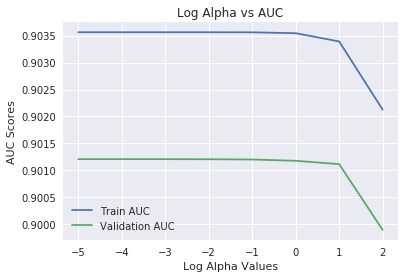



Best hyperparam value:  1e-05


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


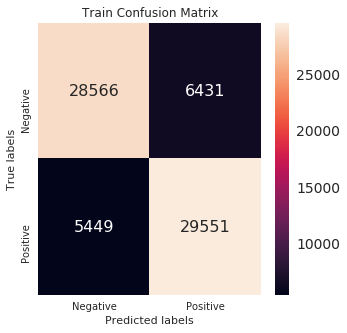

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.839806      0.821272
Recall         0.816241      0.844314
Fscore         0.827856      0.832634
Support    34997.000000  35000.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


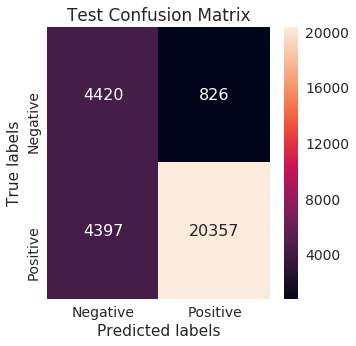

Test Evaluation Metrics : 
               Negative      Positive
Precision     0.501304      0.961006
Recall        0.842547      0.822372
Fscore        0.628600      0.886301
Support    5246.000000  24754.000000


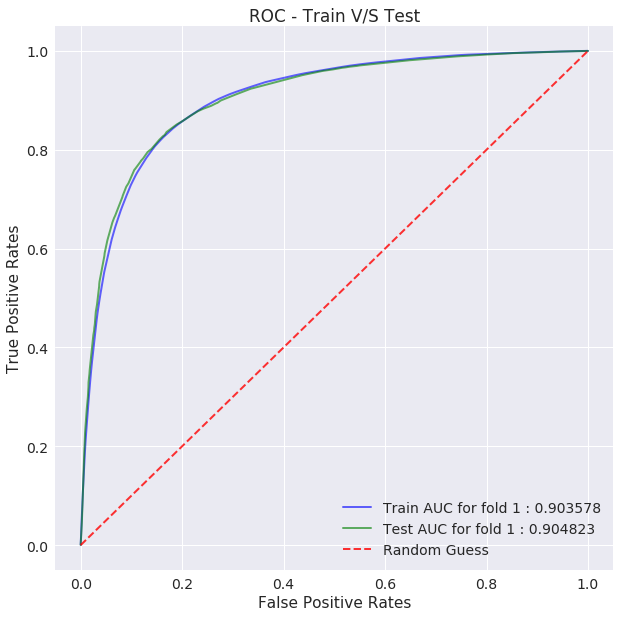

Results Summary: 
 [('Hyper Param', '1e-05'), ('AUC', '0.9048'), ('f-score(-ve)', '62.8600'), ('f-score(+ve)', '88.6301')]


In [11]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                           scaling=False,
                                                                           dim_reduction=False)

# get name of all features in a list
feature_name_list = train_features.columns.values.tolist()

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_a = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> The model is performing well on positve class as the fscore for +ve class is 88% </li>
<li> The model is not performing well on negative class as the fscore for -ve class is 62% </li>
<li> The ROC curves of train, test are overlapping well </li>
<ul>

In [12]:
# word cloud object for displaying feature importances
wc = WordCloud(background_color='white', width=800, height=800)

# form a feature importance data frame
feat_imp_df = pd.DataFrame({'Feature' : feature_name_list, 
                            'Importance (+ve)' : model[0].feature_log_prob_[1],
                            'Importance (-ve)' : model[0].feature_log_prob_[0]}, 
                            index=range(len(feature_name_list)))
feat_imp_df.head()

,Feature,Importance (+ve),Importance (-ve)
0,abl,-7.538247,-8.015246
1,absolut,-7.610099,-8.005688
2,acid,-8.271333,-8.017650
3,actual,-7.199098,-6.982801
4,ad,-7.086040,-7.262110


### [A.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

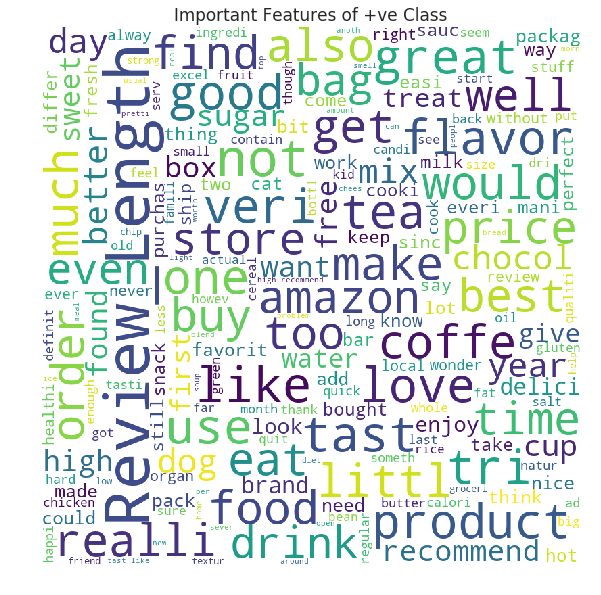

In [13]:
# annotate with feature names (words)
feat_imp_df_positive =  feat_imp_df[['Feature', 'Importance (+ve)']]
feat_imp_df_positive = feat_imp_df_positive.sort_values(['Importance (+ve)'], 
                                                        ascending=False)

# create word cloud
abs_values = abs(feat_imp_df_positive['Importance (+ve)'])
imp_weights = max(abs_values) - abs_values
wc_output = wc.generate_from_frequencies(dict(zip(feat_imp_df_positive['Feature'], 
                                                  imp_weights)))
plt.figure(figsize=(8, 8))
plt.imshow(wc_output)
plt.axis('off')
plt.tight_layout(pad=0.0)
plt.title('Important Features of +ve Class')
plt.show()

In [14]:
# get top 10 important features for +ve class
print('Top 10 important features for +ve class : \n')
feat_imp_df_positive.head(n=10)

Top 10 important features for +ve class : 



,Feature,Importance (+ve)
500,Review_Length,-0.519179
283,not,-4.244497
240,like,-4.991022
437,tast,-5.036223
185,good,-5.187882
165,flavor,-5.220926
250,love,-5.248881
188,great,-5.273904
468,use,-5.290568
303,one,-5.320925


### [A.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

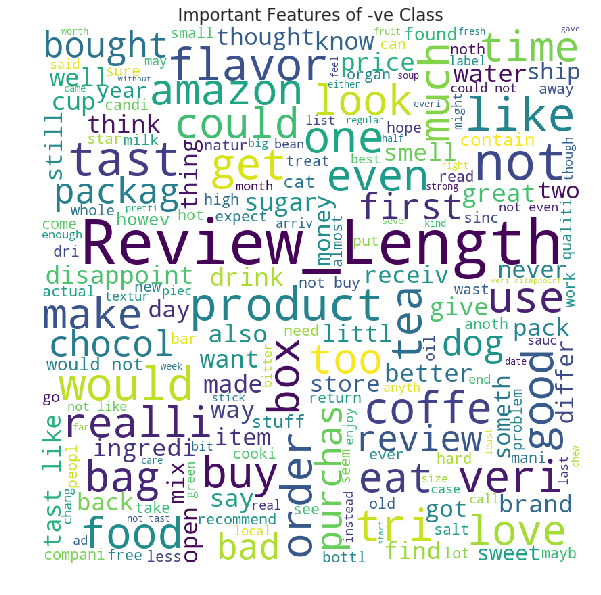

In [15]:
# annotate with feature names (words)
feat_imp_df_negative =  feat_imp_df[['Feature', 'Importance (-ve)']]
feat_imp_df_negative = feat_imp_df_negative.sort_values(['Importance (-ve)'], ascending=False)

# create word cloud
abs_values = abs(feat_imp_df_negative['Importance (-ve)'])
imp_weights = max(abs_values) - abs_values
wc_output = wc.generate_from_frequencies(dict(zip(feat_imp_df_negative['Feature'], imp_weights)))
plt.figure(figsize=(8, 8))
plt.imshow(wc_output)
plt.axis('off')
plt.tight_layout(pad=0.0)
plt.title('Important Features of -ve Class')
plt.show()

In [16]:
# get top 10 important features for -ve class
print('Top 10 important features for -ve class :\n')
feat_imp_df_negative.head(n=10)

Top 10 important features for -ve class :



,Feature,Importance (-ve)
500,Review_Length,-0.520892
283,not,-3.793111
437,tast,-4.754107
240,like,-4.839897
345,product,-5.001313
495,would,-5.175136
303,one,-5.277004
165,flavor,-5.329532
463,tri,-5.449927
472,veri,-5.479246


## Observation

%%HTML
<ul>
<li> The word 'Review_Length' is found almost equally good in deciding label as + ve and -ve </li>
<li> The engineered feature 'review_length' is also helpful in deciding the clasess</li>
<li> Words like 'Review_Length', 'not', 'tast', 'like' are found in both +ve & -ve class </li>
<li> The word 'good' can be seen as a dominant feature in + ve class and 'product' as a dominat one in -ve class.
     These two words seems very useful in distinguishing between + ve , -ve class</li>
</ul>

## [B] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [17]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/train_bigram_tfidf.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/test_bigram_tfidf.csv',
    'train_size' : 70000,
    'test_size' : 30000,
    'hyperparam_list' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100] 
}

Train df shape (69997, 503)
Class label distribution in train df:
 1    35000
0    34997
Name: Label, dtype: int64
Test df shape (30000, 503)
Class label distribution in test df:
 1    24754
0     5246
Name: Label, dtype: int64
Shape of ->  train features :69997,501, test features: 30000,501
Shape of -> train labels :69997, test labels: 30000


 The Log Alpha vs AUC score plot


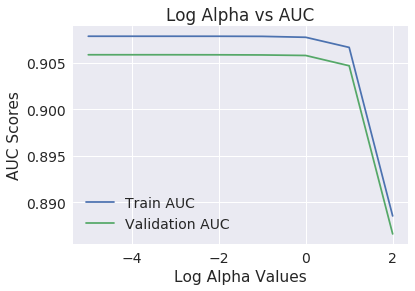



Best hyperparam value:  1e-05


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


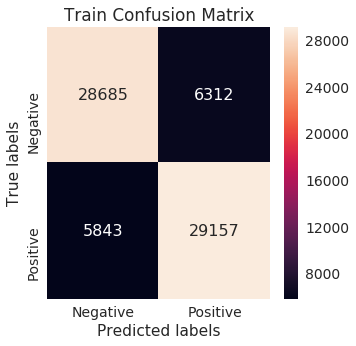

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.830775      0.822042
Recall         0.819642      0.833057
Fscore         0.825171      0.827513
Support    34997.000000  35000.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


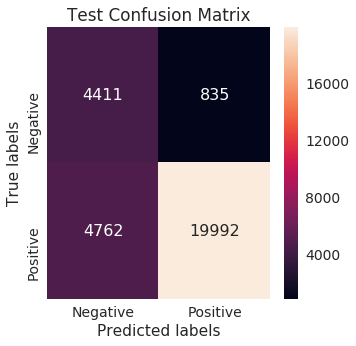

Test Evaluation Metrics : 
               Negative      Positive
Precision     0.480868      0.959908
Recall        0.840831      0.807627
Fscore        0.611832      0.877208
Support    5246.000000  24754.000000


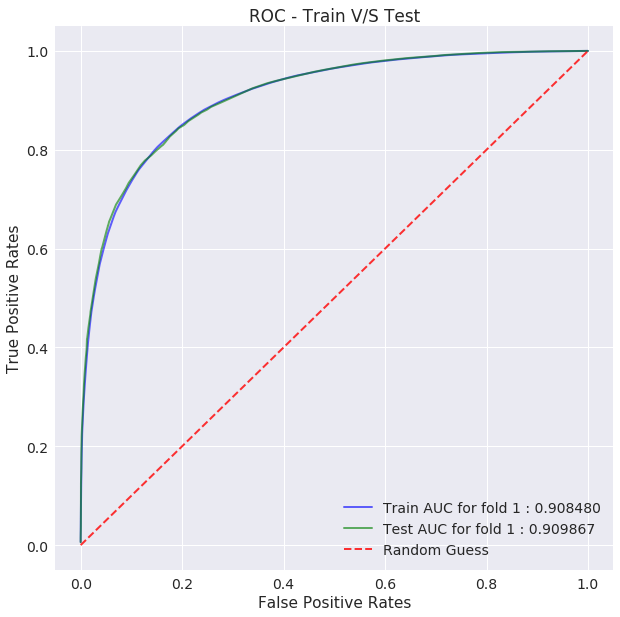

Results Summary: 
 [('Hyper Param', '1e-05'), ('AUC', '0.9099'), ('f-score(-ve)', '61.1832'), ('f-score(+ve)', '87.7208')]


In [18]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=False,
                                                                            dim_reduction=False)

# get name of all features in a list
feature_name_list = train_features.columns.values.tolist()

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_b = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> The train, test ROC curves are well overlapping </li>
</ul>

In [19]:
# word cloud object for displaying feature importances
wc = WordCloud(background_color='white', width=800, height=800)

# form a feature importance data frame
feat_imp_df = pd.DataFrame({'Feature' : feature_name_list, 
                            'Importance (+ve)' : model[0].feature_log_prob_[1],
                            'Importance (-ve)' : model[0].feature_log_prob_[0]}, 
                            index=range(len(feature_name_list)))
feat_imp_df.head()

,Feature,Importance (+ve),Importance (-ve)
0,abl,-8.742422,-9.378704
1,absolut,-8.725371,-9.242838
2,acid,-9.630804,-9.518430
3,actual,-8.730117,-8.514691
4,ad,-8.582567,-8.817066


### [B.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

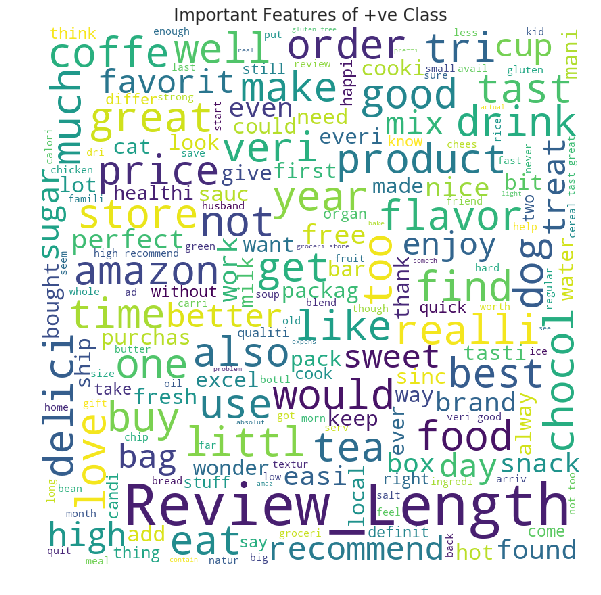

In [20]:
# annotate with feature names (words)
feat_imp_df_positive =  feat_imp_df[['Feature', 'Importance (+ve)']]
feat_imp_df_positive = feat_imp_df_positive.sort_values(['Importance (+ve)'], ascending=False)

# create word cloud
abs_values = abs(feat_imp_df_positive['Importance (+ve)'])
imp_weights = max(abs_values) - abs_values
wc_output = wc.generate_from_frequencies(dict(zip(feat_imp_df_positive['Feature'], 
                                                  imp_weights)))
plt.figure(figsize=(8, 8))
plt.imshow(wc_output)
plt.axis('off')
plt.tight_layout(pad=0.0)
plt.title('Important Features of +ve Class')
plt.show()

In [21]:
# get top 10 important features for +ve class
print('Top 10 important features for +ve class : \n')
feat_imp_df_positive.head(n=10)

Top 10 important features for +ve class : 



,Feature,Importance (+ve)
500,Review_Length,-0.096354
283,not,-6.677516
188,great,-6.812285
250,love,-6.826352
185,good,-6.958208
443,tea,-7.018903
437,tast,-7.023548
240,like,-7.029118
165,flavor,-7.053729
468,use,-7.094215


### [B.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

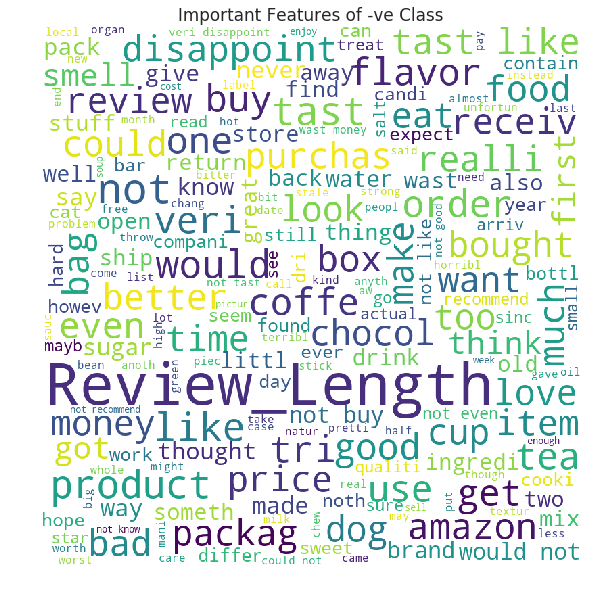

In [22]:
# annotate with feature names (words)
feat_imp_df_negative =  feat_imp_df[['Feature', 'Importance (-ve)']]
feat_imp_df_negative = feat_imp_df_negative.sort_values(['Importance (-ve)'], ascending=False)

# create word cloud
abs_values = abs(feat_imp_df_negative['Importance (-ve)'])
imp_weights = max(abs_values) - abs_values
wc_output = wc.generate_from_frequencies(dict(zip(feat_imp_df_negative['Feature'], 
                                                  imp_weights)))
plt.figure(figsize=(8, 8))
plt.imshow(wc_output)
plt.axis('off')
plt.tight_layout(pad=0.0)
plt.title('Important Features of -ve Class')
plt.show()

In [23]:
# get top 10 important features for -ve class
print('Top 10 important features for -ve class :\n')
feat_imp_df_negative.head(n=10)

Top 10 important features for -ve class :



,Feature,Importance (-ve)
500,Review_Length,-0.090754
283,not,-6.171847
437,tast,-6.759895
240,like,-6.884143
345,product,-6.910533
495,would,-7.100481
165,flavor,-7.201804
303,one,-7.223312
88,coffe,-7.271277
472,veri,-7.294378


%%HTML
<ul>
<li> The words 'great', 'love', 'good' are found very useful in deciding + ve class</li>
<li> The words 'would', 'product' are found very useful in deciding - ve class</li>
<li> Words like 'Review_Length', 'not', 'tast', 'like' are found in both +ve & -ve class </li>
</ul>

# Procedure Summary

%%HTML
<ol>
<li> Train the multinomial naive bayes algorithm with bow & tf-idf dataset </li>
<li> Fine tune the hyper parameter using cross validation method </li>
<li> Use calibration model to approximate the probaility as the NaiveBayes model doesn't provide true probability
     value </li>
<li> Choose the best (hyper parameter) alpha value based on the auc score </li>
<li> Train and evaluate the final model using the best hyper param we got </li>
<li> Identify the most important features for both + ve, -ve class and represent the important ones
     using  the wordcloud </li>
</ol>

# Results Summary

In [24]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Vectorizer', 'Hyper-Param (alpha)', 'AUC', 'Fscore (-ve)', 'Fscore (+ve)']
Pret_table.title = 'Multinomial NaiveBayes Results Summary'

In [25]:
# Brute Force
Pret_table.add_row(['BoW'] + ptabe_entry_a)
Pret_table.add_row(['TF-IDF'] + ptabe_entry_b)

In [26]:
print(Pret_table)

+-------------------------------------------------------------------------+
|                  Multinomial NaiveBayes Results Summary                 |
+------------+---------------------+--------+--------------+--------------+
| Vectorizer | Hyper-Param (alpha) |  AUC   | Fscore (-ve) | Fscore (+ve) |
+------------+---------------------+--------+--------------+--------------+
|    BoW     |        1e-05        | 0.9048 |   62.8600    |   88.6301    |
|   TF-IDF   |        1e-05        | 0.9099 |   61.1832    |   87.7208    |
+------------+---------------------+--------+--------------+--------------+


# Conclusions

%%HTML
<ul>
<li> The performance on +ve class is really good (above 87% f1-score)</li>
<li> The performance on -ve class is not really good as the f1-score is less than 63% </li>
<li> For this particular classification problem low alpha value showed good performance </li>
<li> Naive Bayes model being very simple and makes naive assumption about features may not 
     give good results when features depends to some extend. Need to try more complex
     model to improve the results </li>
</ul>